# Simulations

Initial runs and analysis of offline evaluation simulations.

## Setup

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lenskit import crossfold as xf
from lenskit import batch
from lenskit import topn
from lenskit.algorithms import basic
from lenskit.metrics import topn as tnmetrics
import simulation_utils as sims

## Datasets

Import generator and sampler functions, and assign to variables

In [2]:
gen_unif = sims.generate_uniform
gen_ibp = sims.generate_ibppl
sample_unif = sims.sample_uniform
sample_pop = sims.sample_popular

## Algorithms

Setup algorithms:
- Oracle
- Popular
- Random

In [3]:
random_algo = basic.Random()
popular_algo = basic.Popular()
oracle_algo = sims.Oracle(None)

## Experiments

Define a function to run a single experiment, including:
- generate user true preferences
- sample observations from the generated preferences
- train algorithms on observations or preferences (if Oracle)
- recommend items to test users
- compute evaluation metrics using true preferences and observations

In [4]:
def run_experiment(generator, sampler, algorithms, metrics):
    # TODO: make generator and sampler parameters configurable
    pref = generator(943, 1682, 0.5)
    pref['rating'] = 1
    obs = sampler(pref, 0.2)
    # let's get some irrelevant items
    obs_dens = (obs.pivot(index='user', columns='item', values='rating')
                .reset_index()
                .melt(id_vars='user', var_name='item', value_name='rating'))
    obs_dens['item'] = obs_dens['item'].astype(np.int64)
    # split data
    splits = xf.partition_users(obs_dens, 1, xf.SampleFrac(0.2))
    train, test = next(splits)
    obs_train = train.dropna()
    obs_test = test.dropna()
    pref_test = (test.merge(pref, how='left', 
                            on=['user', 'item'], suffixes=['_obs', ''])
                 .drop('rating_obs', axis=1)
                 .dropna())
    # get algorithm names
    # TODO: fix Random algorithm's `__str__` to avoid this.
    algo_names = map(lambda x: str(x).split('.')[-1].split()[0], algorithms)
    nalgo = len(algorithms)
    # map the `eval_algorithm` function to each algorithm
    users = obs_test['user'].unique()
    recs = map(sims.eval_algorithm, algo_names, algorithms, [obs_train]*nalgo, 
              [pref]*nalgo, [users]*nalgo, [50]*nalgo)
    recs = pd.concat(recs, axis=0, ignore_index=True)
    # compute metrics based on the test data (observations and true preferences)
    eval_obs = sims.compute_metrics(recs, metrics, obs_test)
    eval_obs = (eval_obs.drop('user', axis=1)
                .groupby('algorithm', as_index=False)
                .mean())
    eval_pref = sims.compute_metrics(recs, metrics, pref_test)
    eval_pref = (eval_pref.drop('user', axis=1)
                .groupby('algorithm', as_index=False)
                .mean())
    eval_res = eval_obs.merge(eval_pref, how='left', 
                          on='algorithm', suffixes=['_obs', '_pref'])
    return eval_res

Define a wrapper function to run multiple experiments in parallel

In [5]:
def _parallel_wrapper(args):
    from datetime import datetime
    # make children processes use different seeds
    seed = datetime.now().microsecond
    np.random.seed(seed)
    eval_res = run_experiment(*args)
    return eval_res

In [6]:
def run_sims(ntimes=100, nthread=None, *args):
    if ntimes <= 0:
        raise ValueError("ntimes must be greater than 0")
    if len(args) == 0:
        raise ValueError("args must not be empty")
    from multiprocessing import Pool
    # create args iterable for each run 
    args_list = [args] * ntimes
    results = None
    with Pool(nthread) as p:
        result = p.map(_parallel_wrapper, args_list)
        results = pd.concat(result, axis=0, ignore_index=True)
    return results

Let's run simulations!

In [7]:
ibp_unif = run_sims(100, 12, gen_ibp, sample_unif, 
                    [random_algo, popular_algo, oracle_algo], 
                    ['precision', 'recall', 'recip_rank', 'ndcg'])

In [ ]:
ibp_pop = run_sims(100, 12, gen_ibp, sample_pop, 
                    [random_algo, popular_algo, oracle_algo], 
                    ['precision', 'recall', 'recip_rank', 'ndcg'])

In [ ]:
unif_unif = run_sims(100, 12, gen_unif, sample_unif, 
                    [random_algo, popular_algo, oracle_algo], 
                    ['precision', 'recall', 'recip_rank', 'ndcg'])

In [ ]:
unif_pop = run_sims(100, 12, gen_unif, sample_pop, 
                    [random_algo, popular_algo, oracle_algo], 
                    ['precision', 'recall', 'recip_rank', 'ndcg'])

In [8]:
ibp_unif.head()

,algorithm,precision_obs,recall_obs,recip_rank_obs,ndcg_obs,precision_pref,recall_pref,recip_rank_pref,ndcg_pref
0,Oracle,0.048441,0.073575,0.155454,0.280651,0.238134,0.072200,0.464112,0.558427
1,Popular,0.043606,0.065952,0.136063,0.267413,0.218176,0.066146,0.434768,0.541195
2,Random,0.007508,0.011195,0.032597,0.089253,0.034910,0.010580,0.121246,0.244824
3,Oracle,0.047529,0.069872,0.154700,0.276938,0.235376,0.069179,0.456413,0.556547
4,Popular,0.044645,0.065715,0.135786,0.267557,0.225196,0.066256,0.423917,0.545548


Save results

In [145]:
import pickle

with open('build/ibp-unif-eval-results.pickle', 'wb') as f:
    pickle.dump(ibp_unif, f)

In [ ]:
with open('build/ibp_pop-eval-results.pickle', 'wb') as f:
    pickle.dump(ibp_pop, f)

In [ ]:
with open('build/unif_unif-eval-results.pickle', 'wb') as f:
    pickle.dump(unif_unif, f)

In [ ]:
with open('build/unif_pop-eval-results.pickle', 'wb') as f:
    pickle.dump(unif_pop, f)

Load pickles

In [ ]:
with open('build/ibp-unif-eval-results.pickle', 'rb') as f:
    ibp_unif = pickle.load(f)

In [ ]:
with open('build/ibp_pop-eval-results.pickle', 'rb') as f:
    ibp_pop = pickle.load(f)

In [ ]:
with open('build/unif_unif-eval-results.pickle', 'rb') as f:
    unif_unif = pickle.load(f)

In [ ]:
with open('build/unif_pop-eval-results.pickle', 'rb') as f:
    unif_pop = pickle.load(f)

### Plot the results

In [14]:
def extract_result(sims_results, metric='precision'):
    obs_label = ''.join([metric, '_obs'])
    pref_label = ''.join([metric, '_pref'])
    result = sims_results[['algorithm', obs_label, pref_label]]
    result = result.rename(columns={obs_label: 'observation', pref_label: 'preference'})
    result['error'] = result['observation'] - result['preference']
    return result

In [142]:
def plot_vertical_mean(a, **kwargs):
    x = a.mean()
    plt.axvline(x)
    bottom, top = plt.ylim()
    xid = round(x+0.0002, 4)
    yid = round(top*0.8)
    text = "mean={:.2f}".format(x)
    plt.text(xid, yid, text, rotation=90)

In [143]:
def plot_metric(sims_results, metric='precision'):
    res = extract_result(sims_results, metric)
    res_tall = res.melt(id_vars='algorithm', var_name='type', value_name='metric')
    g = sns.FacetGrid(res_tall, col='algorithm', row='type', 
                      sharey=False, sharex=False, height=5,
                      margin_titles=True)
    (g.map(sns.distplot, 'metric')
     .set_titles(row_template='', col_template='{col_name}')
     .set_axis_labels(metric, 'count'))
    g.map(plot_vertical_mean, 'metric')
    plt.show()

Models:

- IBP
- Uniform

**Precision**

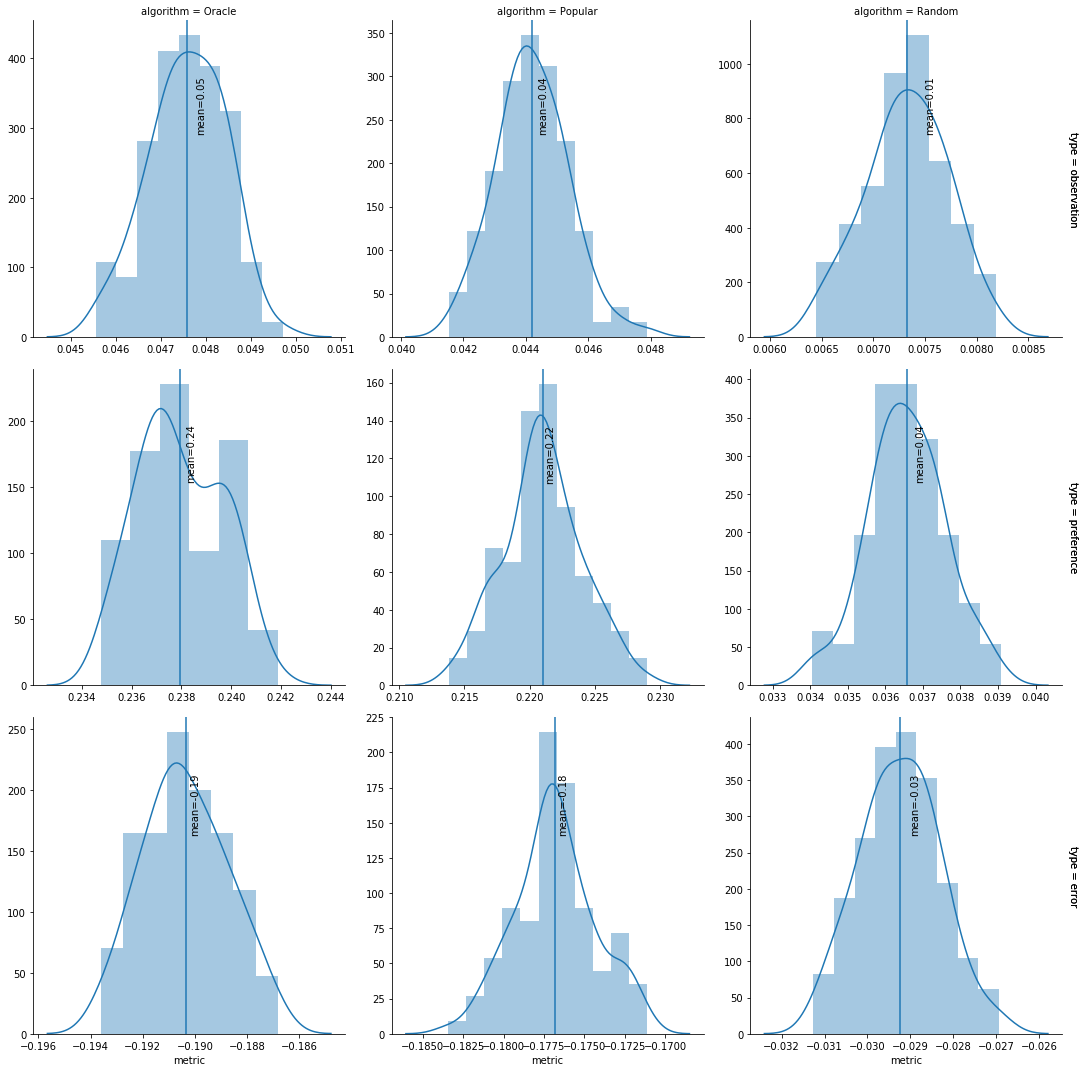

In [144]:
plot_metric(ibp_unif, 'precision')

**Recall**

/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


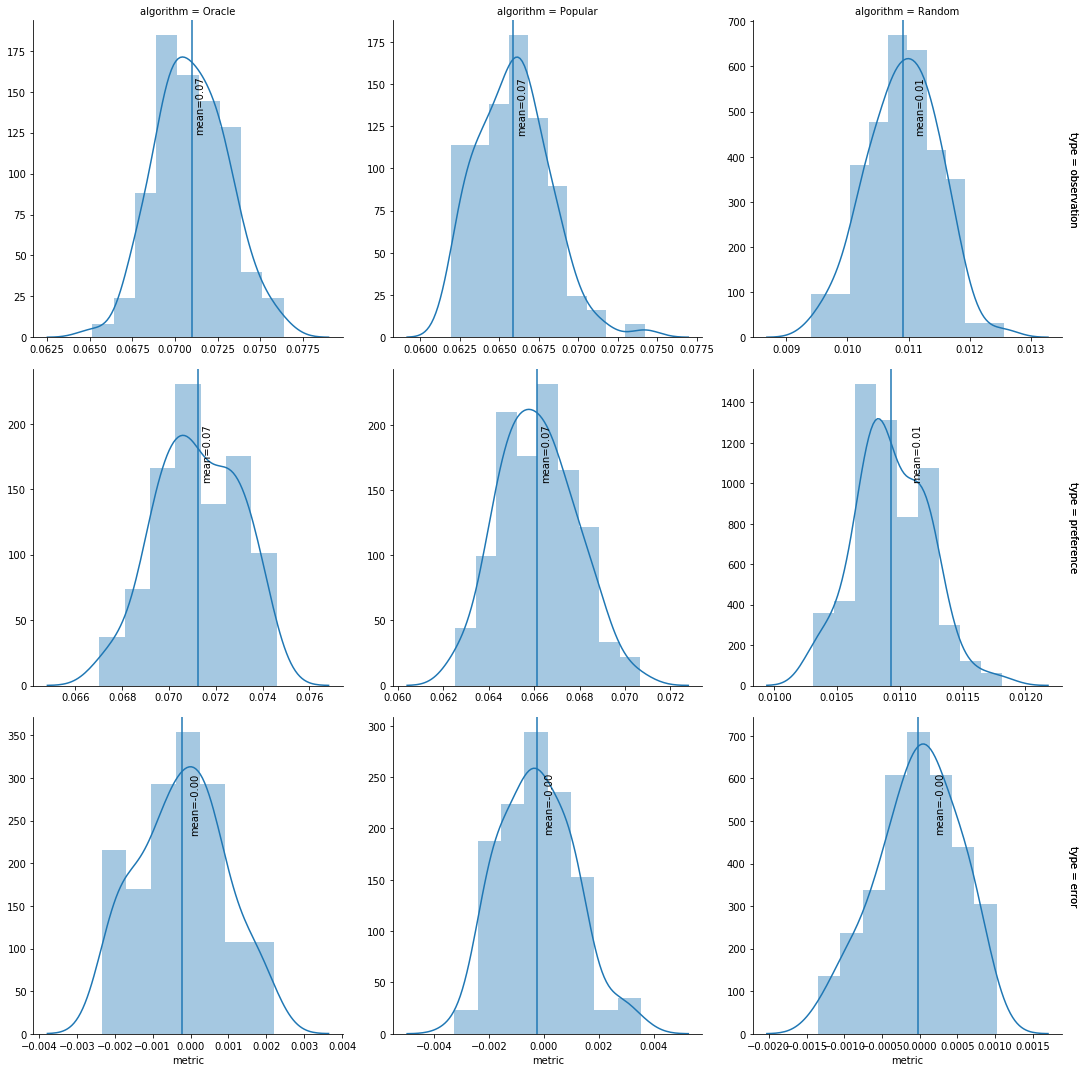

In [146]:
plot_metric(ibp_unif, 'recall')

**recip_rank**

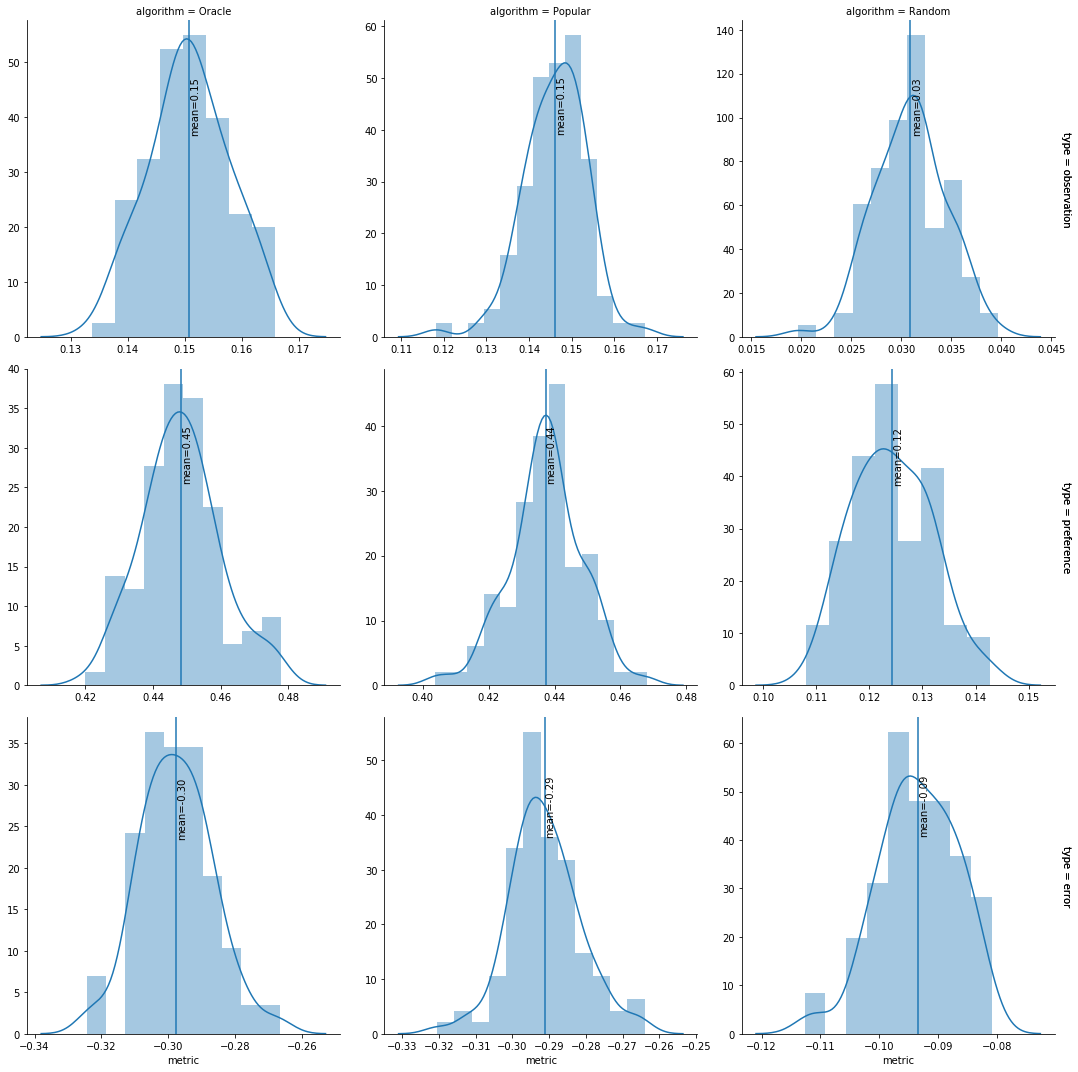

In [147]:
plot_metric(ibp_unif, 'recip_rank')

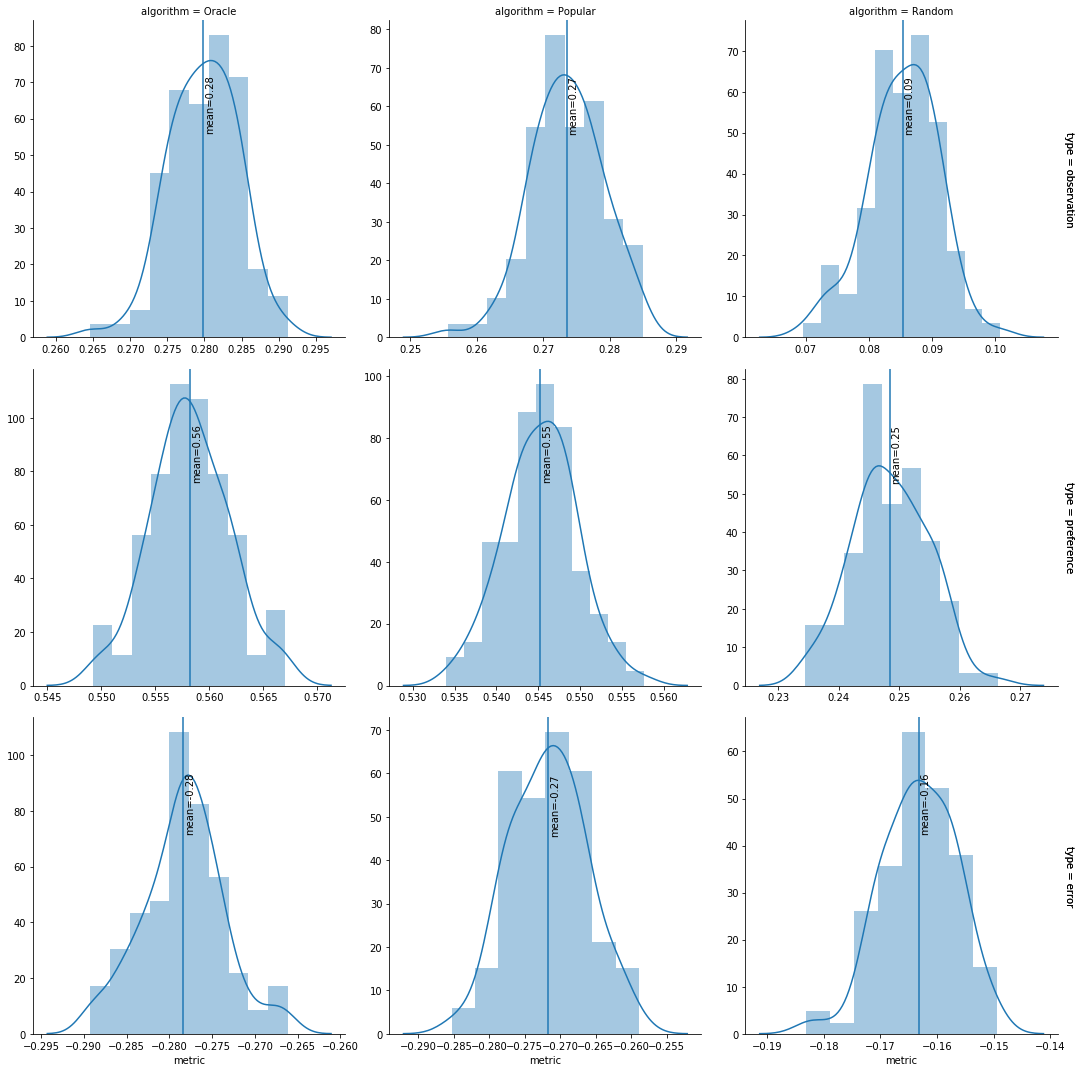

In [148]:
plot_metric(ibp_unif, 'ndcg')